In [10]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
faithful_df=pd.read_csv('faithful.csv')
faithful_df


,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85
...,...,...,...
267,268,4.117,81
268,269,2.150,46
269,270,4.417,90
270,271,1.817,46


In [12]:
del faithful_df['Unnamed: 0']
faithful_df

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


In [13]:
def generateZ(mu,cov):
  x, y = np.meshgrid(np.linspace(1,6,1000),np.linspace(30,100,1000))
  xy = np.column_stack([x.flat, y.flat])
  Z = mvn.pdf(xy, mu, cov).reshape(x.shape)
  return x,y,Z

In [14]:
def Estep(df,mu,sigma,pi):
    X=df.to_numpy()
    K=sigma.shape[0]
    N=X.shape[0]
    gamma = np.zeros(shape=(N, K))
    for k in range(K):
        gamma[:, k] = mvn.pdf(X, mu[k], sigma[k]) * pi[k]
    gamma = gamma/np.sum(gamma, axis=1, keepdims=True)
    return gamma
  

In [15]:
def Mstep(df,gamma):
    X=df.to_numpy()
    N=X.shape[0]
    K=gamma.shape[1]
    pi = np.sum(gamma, axis=0)/np.sum(gamma)
    mu = X[np.random.choice(N, size=K, replace=False), :]
    sigma = np.zeros(shape=(K, X.shape[1], X.shape[1]), dtype=np.float)
    for k in range(K):
        mu[k, :] = np.sum(gamma[:, k].reshape(-1,1) * X, axis=0) / np.sum(gamma[:, k], keepdims=True)
        sigma[k, :, :] = np.sum(gamma[:, k].reshape(-1, 1, 1) * ((X-mu[k, :]).reshape(N, X.shape[1], 1)@(X-mu[k, :]).reshape(N, 1, X.shape[1])), axis=0) /np.sum(gamma[:, k])
    return mu, sigma, pi

In [16]:
def logLikelihood(df,gamma,sigma,mu,pi):
    X = df.to_numpy()
    K = mu.shape[0]
    llh=0
    for k in range(K):
        llh += np.sum(gamma[:, k] * (np.log(mvn.pdf(X, mean=mu[k], cov=sigma[k])) + np.log(pi[k])))
    return llh

In [17]:
def EM(df,K,delta=0.001):
    X=df.to_numpy()
    N, D = X.shape
    mu = X[np.random.choice(N, size=K, replace=False), :]
    pi = np.ones(shape=(K), dtype=np.float128)/K
    sigma = np.zeros(shape=(K, D, D), dtype=np.float128)
    for d in range(D):
        sigma[:, d, d] = np.var(X[:, d])/10
        
    cur_llh = np.float(1e9)
    prev_llh=0.0
    iter=0
    while(abs(cur_llh-prev_llh)>delta):
        gamma = Estep(df, mu, sigma, pi)
        mu, sigma, pi = Mstep(df, gamma)
        
        prev_llh = cur_llh
        cur_llh = logLikelihood(df, gamma, sigma, mu, pi)

        labels = np.argmax(gamma, axis=1)
        iter=iter+1
        plt.figure()
        c=['blue','red','black']

        plt.scatter(faithful_df['eruptions'], faithful_df['waiting'],c=gamma[:,1],cmap='cool')
        for i in range(0,K):
            x,y,z=generateZ(mu[i],sigma[i])
            plt.contour(x, y, z,colors=c[i])
        plt.show()


    return mu, sigma, pi, gamma, labels
    
  
  

/tmp/ipykernel_48760/3668693942.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cur_llh = np.float(1e9)
/tmp/ipykernel_48760/295717679.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigma = np.zeros(shape=(K, X.shape[1], X.shape[1]), dtype=np.float)


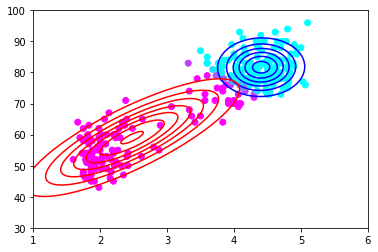

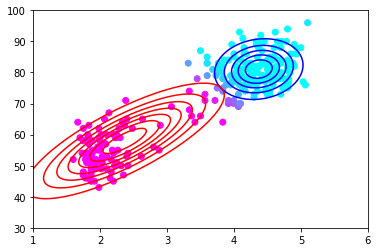

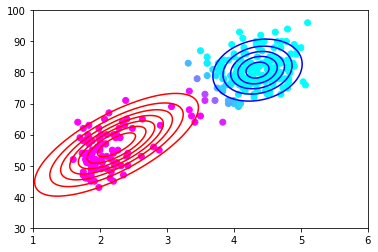

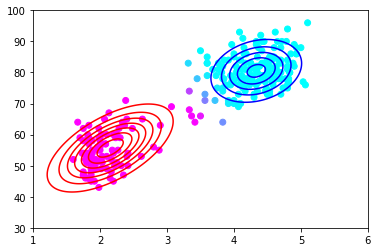

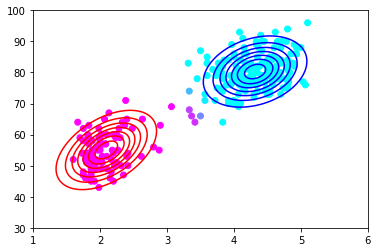

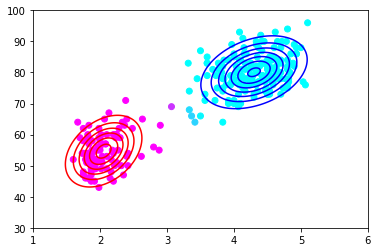

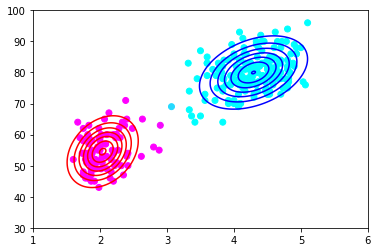

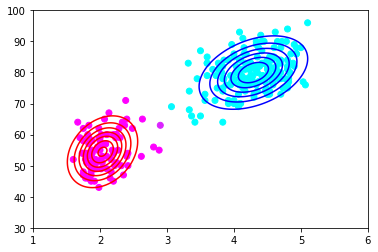

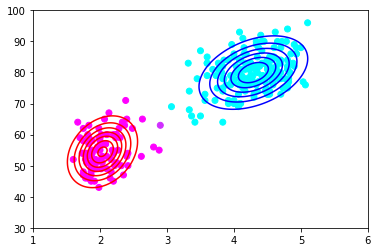

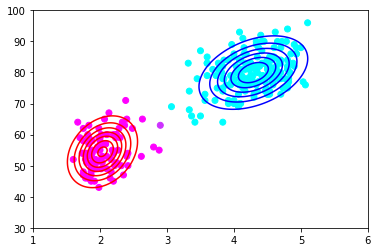

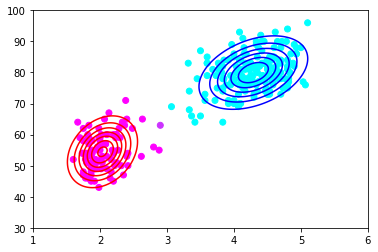

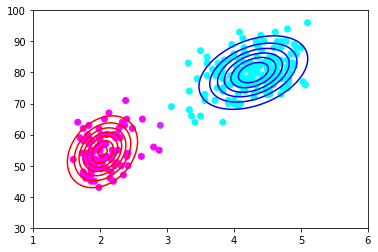

In [18]:
mu, sigma, pi, gamma, labels=EM(faithful_df,2)